# Raster Analytics - Calculating wildfire landslide Risk

This project is based off of https://github.com/Esri/arcgis-python-api/blob/master/samples/04_gis_analysts_data_scientists/calculate_post_fire_landslide_risk.ipynb for learning purposes. 

In October 2017, wildfires raged through Sonoma and Napa counties, devastating surrounding communities. In the wake of these fires, the burn scars could cause further risk to public safety from a different kind of disaster: landslides. Post-fire landslides are particularly hazardous because there is more erosion and weaker soil in burned areas without vegetation to anchor the topsoil.

Groups handling rehabilitation, emergency planning and mitigation after a wildfire need to assess the vulnerability of the landscape to landslides. In this notebook, we will provide local emergency management teams a summary of post-wildfire landslide risk, so officials can target mitigation efforts to the most vulnerable watershed basins.

We will use the imagery layers to assess landslide risk per watershed within the burn area. We will create a landslide risk map and then summarize the landslide risk based on watershed sub-basins. We will use raster function chains to derive a burn severity map, a topographic slope map, and a landcover index map. These individual processing chains will be combined into one processing chain for distributed processing on the Raster Analytics server and then be summarized by watershed sub-basins.

##### Import required Libraries

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *

In [2]:
gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
arcgis.raster.analytics.is_supported(gis)

True

# Get data
For this analysis we need the following datasets

  - Landsat 8 imagery for before (Before_L8)-
  - Landast 8 imagery for after (After_L8) the wildfire
  - DEM (digital elevation model) showing the elevation of the terrain
  - NLCD (National Landcover Dataset) showing land use and predominant vegetation type
  - watershed basin dataset
In the cells below, we access these datasets from the GIS

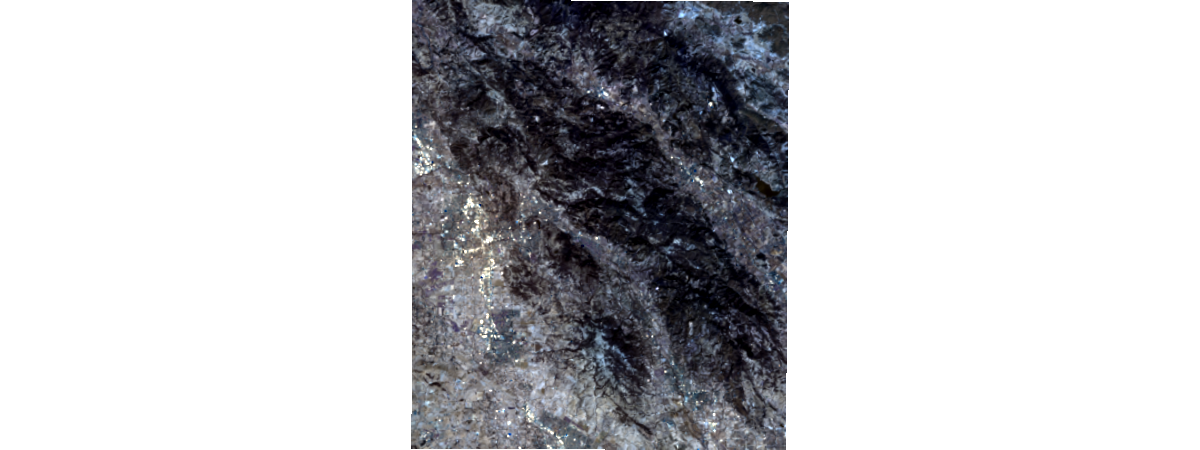

In [3]:
before_l8 = gis.content.search('title:Before_L8 owner:api_data_owner',
                               item_type = "Image Service",
                               outside_org=True)[0].layers[0]
after_l8 = gis.content.search('title:After_L8 owner:api_data_owner',
                              item_type = "Image Service",
                              outside_org=True)[0].layers[0]

before_l8

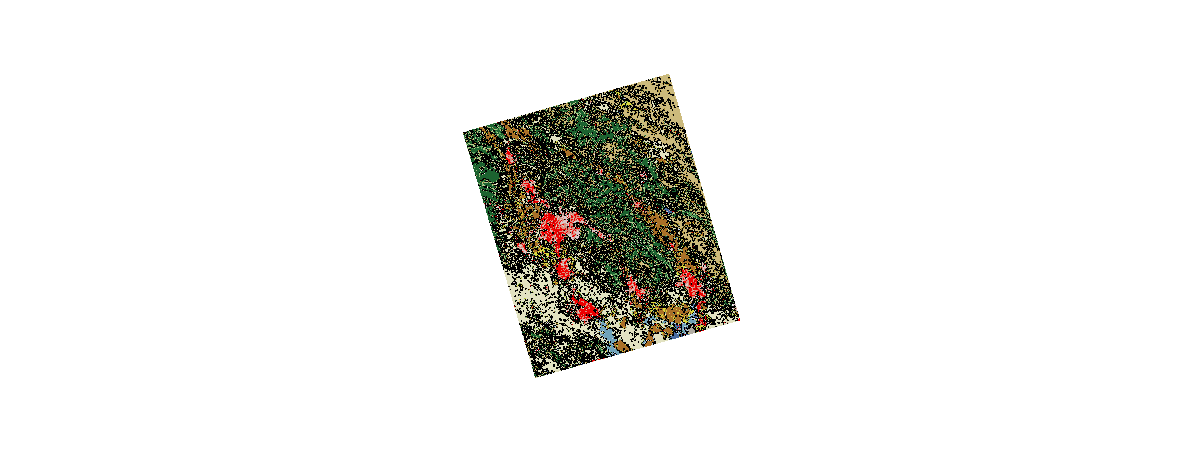

In [4]:
dem = gis.content.search('title:Sonoma_DEM owner:api_data_owner',
                         item_type = "Image Service",
                         outside_org=True)[0].layers[0]
nlcd = gis.content.search('title:Sonoma_NLCD2011 owner:api_data_owner',
                          item_type = "Image Service",
                          outside_org=True)[0].layers[0]
basins = gis.content.search('title:Sonoma_Basins owner:api_data_owner',
                            item_type = "Image Service",
                            outside_org=True)[0].layers[0]

# A preview of National Landcover Dataset layer
nlcd

# Create a burn severity map
To compare the burn scars on the before and after Landsat imagery, we’ll choose the multispectral bands 5,3,2 to be displayed. The [5,3,2] band combination improves visibility of fire and burn scars. Healthy vegetation is shown in bright red, while stressed vegetation is displayed as dull red. Nonvegetated features such as bare and urban areas are displayed in various shades of gray and blue.

Below, we apply the same bands combination to the before_l8 and after_l8 layers.

In [5]:
infrared_before = extract_band(before_l8,
    band_names = ['sr_band5','sr_band3','sr_band2'])
infrared_after = extract_band(after_l8,
    band_names = ['sr_band5','sr_band3','sr_band2'])

# Visual Assessment
Below, in order to visually compare the burn effects, we create two maps and load the extracted bands of before and after imagery.

In [6]:
# Create two maps to compare before and after imageries side by side
map1 = gis.map(location='-122.58, 38.45', zoomlevel=10)
map2 = gis.map(location='-122.58, 38.45', zoomlevel=10)
map1.layout = Layout(flex='1 1', height='500px', padding='10px')
map2.layout = Layout(flex='1 1', height='500px', padding='10px')
map1.add_layer(infrared_before)
map2.add_layer(infrared_after)
box = HBox([map1, map2])
box

From the maps above, we are able to visually observe the burn scars. Next, let us repeat this process, but this time, we will try to quantify the extent of forest fire.

## Quantitative Assessment
A Normalized Burn Ratio (NBR) can be used to delineate the burned areas and identify the severity of the fire. The formula for NBR is very similar to that of NDVI except that it uses near-infrared band 5 and the short-wave infrared band 7:

NBR = (b5 - B7) / (B5 + B7)
 
The NBR equation was designed to be calculated from reflectance, but it can be calculated from radiance and digital_number (dn) with changes to the burn severity (discussed in the table below). For a given area, an NBR is calculated from an image just prior to the burn and a second NBR is calculated for an image immediately following the burn. Burn extent and severity is evaluated by taking the difference between these two index layers:

NBR = NBR(prefire) - NBR(posttfire)

The meaning of the ∆NBR values can vary by scene, and interpretation in specific instances should always be based on some field assessment. However, the following table from the USGS FireMon program can be useful as a first approximation for interpreting the NBR difference:

-2.0 to 0.1  = Regrowth and unburned
0.1 to 0.27 = Low severity burn
0.27 to 0.44 = medium severity burn
0.44 to 0.66 = moderate severity burn
'> 0.66       = High severity burn

Source: http://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:normalized_burn_ratio

In [7]:
# Calculate before/after NBR indices and their difference
nbr_prefire  = band_arithmetic(before_l8,
                               band_indexes = "(b5 - b7) / (b5 + b7)")
nbr_postfire = band_arithmetic(after_l8,
                               band_indexes = "(b5 - b7) / (b5 + b7)")

nbr_diff = nbr_prefire - nbr_postfire

In [8]:
# Use Remap function to reclassify the NBR difference score to 1-5
nbr_diff_remap = remap(nbr_diff,
                       input_ranges=[-2.0,  0.1,  # Regrowth and Unburned
                                     0.1, 0.27,   # Low Severity burn
                                     0.27, 0.44,  # Medium Severity burn
                                     0.44, 0.66,  # Moderate Severity
                                     0.66, 2.00], # High Severity
                       output_values=[1, 2, 3, 4, 5], 
                       astype='u8')

# Create a colormap to show reclassified NBR indices with different color
burn_severity = colormap(nbr_diff_remap, 
                        colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                  [3, 255, 255, 0], [4, 255, 128, 0], 
                                  [5, 255, 0, 0]])

To view the raster function chain visually, we install graphviz Python library.

In [12]:
conda update --all

Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.



The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - esri/win-64::arcgis==1.9.1=py37_2327
  - esri/win-64::arcpy==2.9=py37_arcgispro_32704
  - defaults/win-64::bottleneck==1.3.4=py37h080aedc_0
  - esri/win-64::cftime==1.5.0=py37_1
  - esri/win-64::gdal==3.3.0=arcgispro_py37_16778
  - esri/win-64::h5py==2.10.0=py37_arcgispro_12
  - esri/noarch::lerc==2.2=py_0
  - esri/win-64::matplotlib==3.4.2=py37_arcgispro_1
  - defaults/win-64::mkl-service==2.3.0=py37h196d8e1_0
  - defaults/win-64::mkl_fft==1.3.0=py37h46781fe_0
  - defaults/win-64::mkl_random==1.1.0=py37h675688f_0
  - esri/win-64::netcdf4==1.5.7=py37_arcgispro_2
  - defaults/win-64::numexpr==2.7.3=py37hcbcaa1e_0
  - esri/win-64::numpy==1.20.1=py37_0
  - defaults/win-64::pandas==1.3.5=py37h6214cd6_0
  - esri/noarch::saspy==3.7.3=py_0
  - defaults/win-64::scipy==1.6.2=py37h14eb087_0
  - esri/win-64::swat==1.9.3=py37_0
  - defaults/noarch::xarray==0.17.0=pyh

In [ ]:
! conda install graphviz -y

In [10]:
# Overview of what raster functions have been applied to 
# create burn_serverity layer
burn_severity.draw_graph()

Graphviz needs to be installed. pip install graphviz


UnboundLocalError: local variable 'Digraph' referenced before assignment

In [ ]:
# Visualize burnt areas
burn_severity

So far, we have computed the NBR on images from before and after the burn, and computed the NBR difference to identify places that have suffered the fire. We've also normalized the values to match a burn severity index, and applied a color map that brings out the extent of fire damage, seen in the image above.

In the next section, we will use the quantitative burn severity image, the DEM, the NLCD, and the watershed basin dataset to predict places that are at a high risk for landslides.

# Create a slope index map
Before we can calculate a landslide risk map, we need to create a slope map. This is a critical layer in determining land stability. Slope steepness is derived from a digital elevation model (DEM). The steeper the slope, the more prone it is to slipping, especially during a rainfall event after stabilizing vegetation has been burned away. Next, we’ll build a raster function chain to calculate percent slope and use it to create a steepness index.

Let's calculate slope, reclassify slope values, and assign color scheme in one raster function chain.

In [13]:
# Create slope index layer with a raster function chain
slope_index = colormap(remap(slope(dem),
                             input_ranges=[0,  5,  # Flat
                                           5, 15,  # Low
                                           15, 25,  # Moderate
                                           25, 35,  # Steep
                                           35, 91], # Very Steep
                             output_values=[1, 2, 3, 4, 5], 
                             astype='u8'),
                       colormap=[[1, 56, 168, 0], [2, 141, 212, 0], 
                                 [3, 255, 255, 0], [4, 255, 128, 0], 
                                 [5, 255, 0, 0]])

# Overview of what raster functions have been applied to 
# create slope_index layer
slope_index.draw_graph()

Graphviz needs to be installed. pip install graphviz


UnboundLocalError: local variable 'Digraph' referenced before assignment

In [ ]:
# Visualize slope index layer
slope_index

# Create the landslide risk map
The landslide risk calculation combines the two variables you just worked with: burn severity and slope. It also includes landcover, which is also important to landslide risk. Vegetation stabilizes slopes via root systems. Wildfire can wipe out much of the stabilizing vegetation. Some types of vegetation have adapted to wildfire, such as species of chaparral, which have root systems that are especially deep underground to survive fires.

In this section, we will first reclassify Landcover into five categories depending on its stabilizing effect on slopes. Then, we'll perform a Weighted Overlay Analysis based on the following three factors to determine the landslide risk in the study area:

 - Burn severity (less severely burned areas have lower landslide risk)
 - Slope (lower slope areas have lower landslide risk)
 - Stability index (higher vegetation-stablized areas have lower landslide risk)
The weighted overlay is a standard GIS analysis technique often used for solving multi-criteria problems such as generating surfaces representing site suitability and travel cost. Weighted overlay is used when a number of factors of varying importance should be considered to arrive at a final decision.

# Reclassify landcover type to reflect vegetation stabiilty

In [ ]:
# Remap landcover to derive values for vegetation stability
stability_index = remap(nlcd,
                        input_ranges=[0,  12, 
                                      21, 23, 
                                      23, 23, 
                                      24, 31, 
                                      31, 44,
                                      52, 52,
                                      71, 71,
                                      81, 81,
                                      82, 82,
                                      90, 95], 
                        output_values=[1, 3, 4, 5, 1, 3, 4, 3, 4, 2], 
                        # 1: very stable 2: stable 3: moderate 
                        # 4: unstable 5: very unstable
                        astype='u8')